# Value-Difference Based Q-Learning

Preston Whitcomb & Evan Schubert

In [13]:
import numpy as np
import gymnasium
import matplotlib.pyplot as plt
from tqdm import tqdm

from agent import Agent
from VDBE_agent import VDBE_agent

### Graphing functions

In [14]:
def calc_q_table_magnitude(q_values : dict):
    # calculate L1 norm of q_value matrix 
    # each key is a column, each value of the key is a row element
    # we take the norm of all columns, 
    # then find the max for the overall matrix norm
    norms = []
    for key in q_values.keys():
        n = np.linalg.norm(list((q_values[key].values())))
        norms.append(n)
    norm_max = max(norms)
    return norm_max

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def graph_x_over_time(x : list, line_label : str, x_label : str, y_label : str, title : str, fig=None, axs=None):
    if fig is None or axs is None:
        fig, axs = plt.subplots() # allows adding on to existing graph
    # graph the data
    axs.plot(x, label=line_label)
    # add or update the labels
    axs.set_xlabel(x_label)
    axs.set_xlabel(y_label)
    axs.set_title(title)
    axs.legend()
    return fig

# Training Loop

In [15]:
def train(agent : Agent, env_name: str, num_episodes=10_000, render=False):
    env = gymnasium.make(env_name, render_mode="human" if render else None)

    magnitudes_over_time = []
    rewards_over_time = []

    for _ in tqdm(range(num_episodes)):
        # Reset environment to start a new episode
        observation, info = env.reset()
        observation = tuple(observation) if type(observation) == np.ndarray else observation
        episode_over = False
        total_reward = 0

        while not episode_over:
            # Choose an action
            action = agent.pi(observation)

            # Take the action and see what happens
            new_observation, reward, terminated, truncated, info = env.step(action)
            new_observation = tuple(new_observation) if type(new_observation) == np.ndarray else new_observation

            # reward: +1 for each step the pole stays upright
            # terminated: True if pole falls too far (agent failed)
            # truncated: True if we hit the time limit (500 steps)

            total_reward += reward
            episode_over = terminated or truncated

            agent.update_Q_learning(new_observation, action, reward, observation, episode_over)

            observation = new_observation

        # store episode results
        q_magnitude = calc_q_table_magnitude(agent.Q)
        magnitudes_over_time.append(q_magnitude)
        rewards_over_time.append(total_reward)
        
    env.close()
    return agent, magnitudes_over_time, rewards_over_time


# Making Agents, Env, and Training Parameters

In [16]:
environments_dict= {"LunarLander-v3": [0, 1, 2, 3], "Blackjack-v1": [0,1], "CliffWalking-v1": [0, 1, 2, 3],"Taxi-v3": [0, 1, 2, 3, 4, 5],}


num_turns_to_train = 200

# Train Agents 

In [17]:
training_histories_per_environment = {env : {agent : {} for agent in ['flat', 'decay', 'vdbe']} for env in environments_dict} # store {env {agent : {'magnitudes' : [], 'rewards' : []} } } 
for env_name in environments_dict:
    # Make the agents with the appropriate action spaces
    flat_epsilon_agent = Agent(environments_dict[env_name])
    epsilon_decay_agent = Agent(environments_dict[env_name], epsilon=1.0, do_epsilon_decay=True)
    vdbe_agent = VDBE_agent(environments_dict[env_name])
    # Train
    print(f"Training flat epsilon on {env_name}...")
    trained_flat_epsilon_agent, flat_mag, flat_reward = train(flat_epsilon_agent, env_name, num_episodes=num_turns_to_train, render=False)
    print(f"Training decaying epsilon on {env_name}...")
    trained_epsilon_decay_agent, decay_mag, decay_reward = train(epsilon_decay_agent, env_name, num_episodes=num_turns_to_train, render=False)
    print(f"Training VDBE on {env_name}...")
    trained_vdbe_agent, vdbe_mag, vdbe_reward = train(vdbe_agent, env_name, num_episodes=num_turns_to_train, render=False)
    # Store results for the current environment
    training_histories_per_environment[env_name]['flat']['magnitudes'] = flat_mag
    training_histories_per_environment[env_name]['flat']['rewards'] = flat_reward
    training_histories_per_environment[env_name]['decay']['magnitudes'] = decay_mag
    training_histories_per_environment[env_name]['decay']['rewards'] = decay_reward
    training_histories_per_environment[env_name]['vdbe']['magnitudes'] = vdbe_mag
    training_histories_per_environment[env_name]['vdbe']['rewards'] = vdbe_reward

Training flat epsilon on LunarLander-v3...


100%|██████████| 200/200 [00:05<00:00, 39.58it/s]


Training decaying epsilon on LunarLander-v3...


100%|██████████| 200/200 [00:05<00:00, 38.95it/s]


Training VDBE on LunarLander-v3...


100%|██████████| 200/200 [00:04<00:00, 45.51it/s]


Training flat epsilon on Blackjack-v1...


100%|██████████| 200/200 [00:00<00:00, 4590.64it/s]


Training decaying epsilon on Blackjack-v1...


100%|██████████| 200/200 [00:00<00:00, 3909.39it/s]


Training VDBE on Blackjack-v1...


100%|██████████| 200/200 [00:00<00:00, 4392.56it/s]


Training flat epsilon on CliffWalking-v1...


100%|██████████| 200/200 [00:00<00:00, 299.35it/s]


Training decaying epsilon on CliffWalking-v1...


100%|██████████| 200/200 [00:01<00:00, 172.96it/s]


Training VDBE on CliffWalking-v1...


100%|██████████| 200/200 [00:00<00:00, 269.41it/s]


Training flat epsilon on Taxi-v3...


100%|██████████| 200/200 [00:00<00:00, 410.35it/s]


Training decaying epsilon on Taxi-v3...


100%|██████████| 200/200 [00:00<00:00, 456.35it/s]


Training VDBE on Taxi-v3...


100%|██████████| 200/200 [00:00<00:00, 369.75it/s]


# Graph magnitudes and rewards

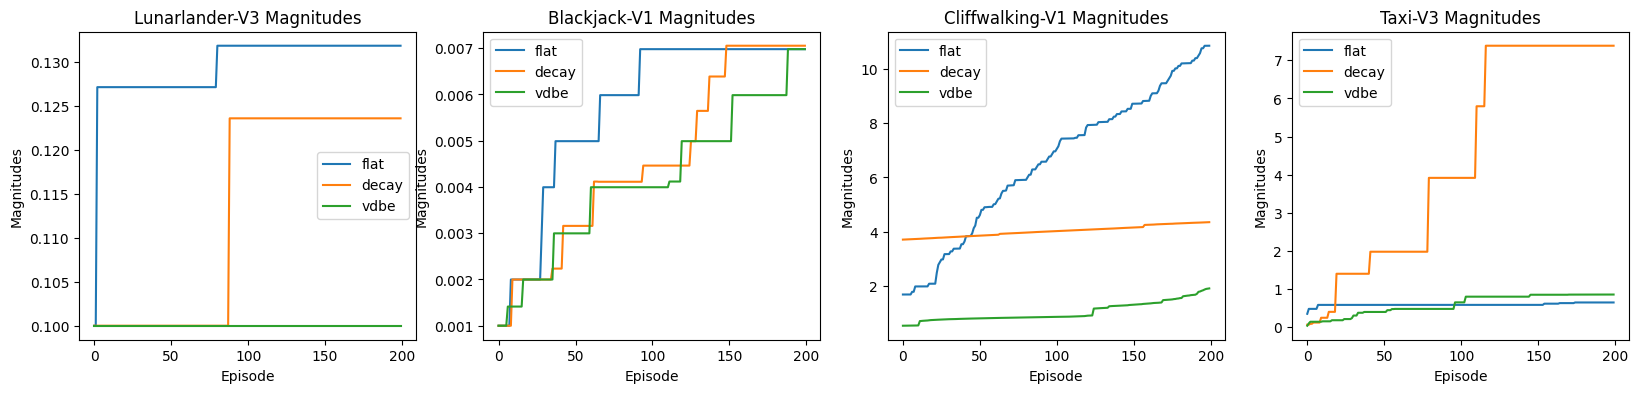

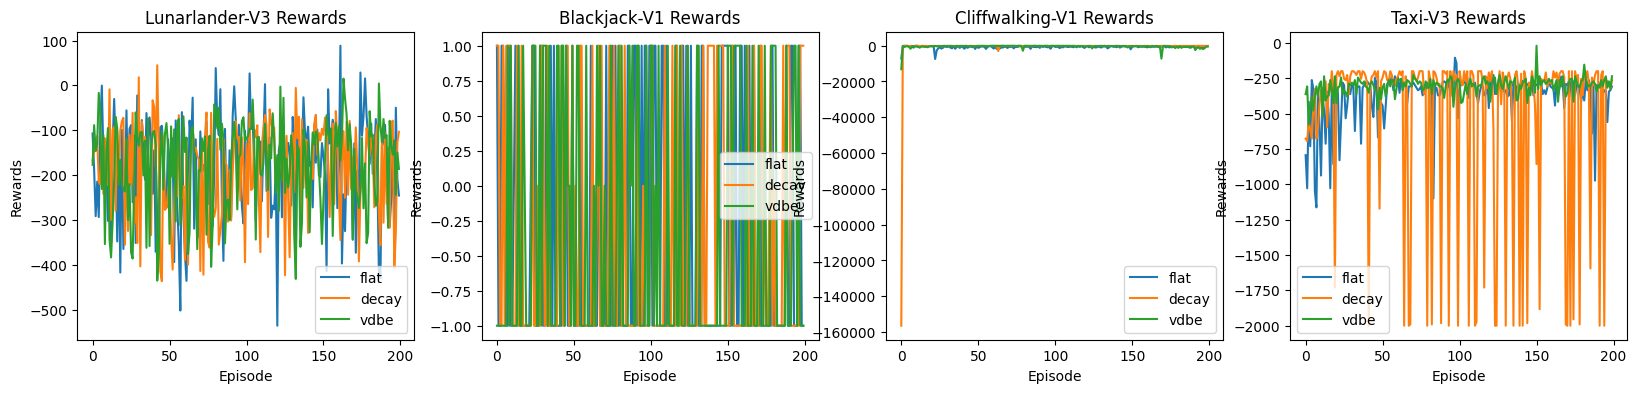

In [21]:
moving_average_step_size = num_turns_to_train // 1
for metric in ['magnitudes', 'rewards']:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    for col, env in enumerate(training_histories_per_environment):
        # plot all magnitudes in a graph
        for agent in training_histories_per_environment[env]:
            data = training_histories_per_environment[env][agent][metric]
            # axs[col].plot(data, label=agent)
            axs[col].plot(moving_average(data, len(data) // moving_average_step_size), label=agent)
        axs[col].set_xlabel("Episode")
        axs[col].set_ylabel(metric.title())
        axs[col].set_title(f"{env.title()} {metric.title()}")
        axs[col].legend()
    fig.savefig(f'{metric}_{num_turns_to_train}_episodes.png')